# Synthesize Speech from Text

This notebook is used to explore synthesizing speech from text.

In [1]:
%matplotlib inline

import sys

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')
sys.path.insert(0, '../third_party/nv-wavenet/pytorch')

In [2]:
import torch

from src.hparams import set_hparams

set_hparams()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load checkpoints

In [3]:
import os

feature_model_checkpoint = ('/home/michaelp/Tacotron-2/experiments/feature_model/'
                           '06_11/03:24:26/checkpoints/step_23453.pt')
signal_model_checkpoint = ('/home/michaelp/Tacotron-2/experiments/signal_model/'
                           '06_12/16:08:22/checkpoints/step_291583.pt')

assert os.path.isfile(feature_model_checkpoint)
assert os.path.isfile(signal_model_checkpoint)

In [4]:
from src.bin.feature_model._utils import load_checkpoint
from src.bin.feature_model._utils import set_hparams

set_hparams()
checkpoint = load_checkpoint(feature_model_checkpoint, device)
text_encoder = checkpoint['text_encoder']
feature_model = checkpoint['model']
'Loaded feature model at step %d' % checkpoint['step']

'Loaded feature model at step 23453'

In [5]:
from src.bin.signal_model._utils import load_checkpoint
from src.bin.signal_model._utils import set_hparams
from src.signal_model import WaveNet

set_hparams('WaveNet')
checkpoint = load_checkpoint(signal_model_checkpoint, device)
signal_model = WaveNet().to(device)
signal_model.load_state_dict(checkpoint['model_state_dict'])
'Loaded signal model at step %d' % checkpoint['step']

'Loaded signal model at step 291583'

## Predict

In [43]:
text = 'Basilar membrane and otolaryngology are not auto-correlations.'

In [44]:
# Ensure your text does not contain unknown characters
assert text_encoder.decode(text_encoder.encode(text)) == text

torch.set_grad_enabled(False)
feature_model.eval()
_ = signal_model.eval() # ``_ = `` prevents printing

In [45]:
encoded = text_encoder.encode(text)
encoded = encoded.unsqueeze(0).to(device)
# predicted_frames [num_frames, batch_size, frame_channels]
_, predicted_frames, _, _ = feature_model(tokens=encoded)
print('Spectrogram Shape:', predicted_frames.shape)

Spectrogram Shape: torch.Size([322, 1, 80])


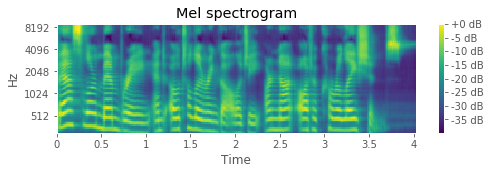

In [46]:
from src.utils import plot_log_mel_spectrogram

plot_log_mel_spectrogram(predicted_frames[:, 0, :].cpu().numpy(), plot_to_numpy=False)

In [47]:
import nv_wavenet
    
from src.audio import mu_law_decode

# [num_frames, batch_size, frame_channels] → [batch_size, num_frames, frame_channels]
predicted_frames = predicted_frames.transpose(0, 1)
# [batch_size, signal_length]
signal = signal_model(predicted_frames, implementation=nv_wavenet.Impl.PERSISTENT)
signal = mu_law_decode(signal)

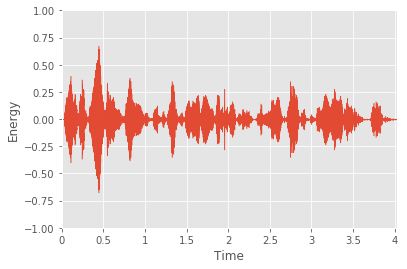

In [48]:
from src.utils import plot_waveform

plot_waveform(signal[0].cpu().numpy(), plot_to_numpy=False)

In [49]:
from IPython.display import Audio

Audio(signal[0].cpu().numpy())